# Setup

Imports everything, make sure that CUDA is enabled.

In [0]:
from __future__ import print_function

import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

from torchvision.utils import save_image

Version 1.3.1
CUDA enabled: True


# Define the Network
First, this sets up the helper function that deals with image load, display, and saving

In [0]:
# TODO: Get a GPU for this (??)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

# Erik: Try forcing the image size to be squares so we don't need to manually resize.
imsize = (imsize, imsize)

# Erik: We've seen this before in DL colabs
loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

unloader = transforms.ToPILImage()  # reconvert into PIL image

def image_loader(image_name):
    image = Image.open(image_name)
    # print('original size', image.size())
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def imshow(tensor, title=None, save=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    pltimage = unloader(image)
    plt.imshow(pltimage)
    plt.axes().set_axis_off()
    if title is not None:
        plt.title(title)
    if save is not None:
        save_image(image, save)
        #plt.savefig(save, transparent=True)
    plt.pause(5) # pause a bit so that plots are updated

This portion of the code defines the loss functions and a function that creates a custom model based on various input parameters

In [0]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

class MultiStyleLoss(nn.Module):

    def __init__(self, target_feature_1, target_feature_2, weight):
        super(MultiStyleLoss, self).__init__()
        self.target1 = gram_matrix(target_feature_1).detach()
        self.target2 = gram_matrix(target_feature_2).detach()
        self.weight = weight

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = self.weight * F.mse_loss(G, self.target1) + (1 - self.weight) *  F.mse_loss(G, self.target2)
        return input

cnn = models.vgg19(pretrained=True).features.to(device).eval()

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img, second_style_img,
                               multi_style_weight,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    if second_style_img is not None:
        assert(multi_style_weight >= 0 and multi_style_weight <= 1)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            if second_style_img is not None:
                target_feature_1 = model(style_img).detach()
                target_feature_2 = model(second_style_img).detach()
                style_loss = MultiStyleLoss(target_feature_1, target_feature_2, multi_style_weight)
            else:
                target_feature = model(style_img).detach()
                style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss) or isinstance(model[i], MultiStyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:21<00:00, 26.7MB/s]


This portion defineds the training code that runs various models

In [0]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, second_style_img = None,
                       multi_style_weight = None, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img,
        second_style_img, multi_style_weight)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

# Sequential Multi-Style Transfer
Ran it through the network twice. Once originally, and then the second time with the output of the first as the new content and the the second style as the new style

colors.jpg    monet.jpg  roses.jpg    selfie.jpg
low_poly.png  ny.jpg	 sample_data  starry.jpg


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


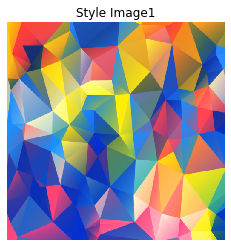

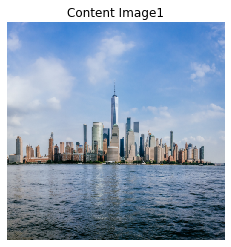

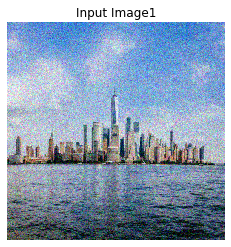

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


run [50]:
Style Loss : 1232.716919 Content Loss: 20.293039

run [100]:
Style Loss : 405.394135 Content Loss: 22.606396

run [150]:
Style Loss : 167.514343 Content Loss: 24.142834

run [200]:
Style Loss : 62.055508 Content Loss: 24.362043

run [250]:
Style Loss : 23.539724 Content Loss: 24.166098

run [300]:
Style Loss : 13.463270 Content Loss: 23.741484

run [350]:
Style Loss : 8.404978 Content Loss: 23.397499

run [400]:
Style Loss : 5.838675 Content Loss: 23.026356

run [450]:
Style Loss : 4.374199 Content Loss: 22.656456

run [500]:
Style Loss : 3.606879 Content Loss: 22.330057

run [550]:
Style Loss : 3.132383 Content Loss: 22.029312

run [600]:
Style Loss : 2.794849 Content Loss: 21.775457



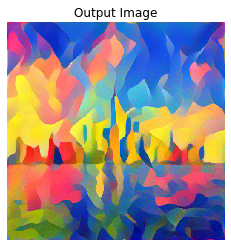

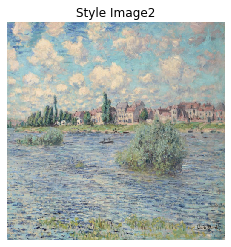

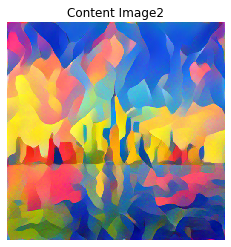

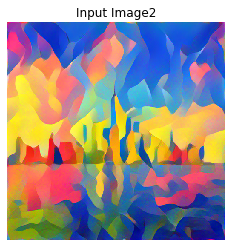

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 61.481056 Content Loss: 24.128906

run [100]:
Style Loss : 12.528822 Content Loss: 20.704088

run [150]:
Style Loss : 7.022777 Content Loss: 17.580570

run [200]:
Style Loss : 3.636258 Content Loss: 16.258717

run [250]:
Style Loss : 1.832022 Content Loss: 15.376856

run [300]:
Style Loss : 1.206169 Content Loss: 14.704396

run [350]:
Style Loss : 0.975046 Content Loss: 14.292995

run [400]:
Style Loss : 0.874609 Content Loss: 14.015425

run [450]:
Style Loss : 0.802991 Content Loss: 13.829474

run [500]:
Style Loss : 0.750834 Content Loss: 13.688810

run [550]:
Style Loss : 0.709148 Content Loss: 13.584311

run [600]:
Style Loss : 0.679014 Content Loss: 13.506088



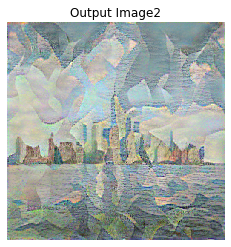

In [0]:
NOISY_START = False
SHOW_INPUT = True

STYLE_WEIGHT = 1000000
CONTENT_WEIGHT = 1
ITERATIONS = 600
!ls
style_img = image_loader("low_poly.png")
content_img = image_loader("ny.jpg")
style_img2 = image_loader("monet.jpg")
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

input_img = content_img.clone()
if NOISY_START:
    input_img = torch.normal(content_img.data, 0.1)
    input_img.data.clamp_(0, 1)

plt.ion()

if SHOW_INPUT:
    plt.figure()
    imshow(style_img, title='Style Image1')

    plt.figure()
    imshow(content_img, title='Content Image1')

    plt.figure()
    imshow(input_img, title='Input Image1')


output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=ITERATIONS,
                            style_weight=STYLE_WEIGHT, content_weight=CONTENT_WEIGHT)
plt.figure()
imshow(output, title='Output Image')
if SHOW_INPUT:
    plt.figure()
    imshow(style_img2, title='Style Image2')

    plt.figure()
    imshow(output, title='Content Image2')

    plt.figure()
    imshow(input_img, title='Input Image2')

output2 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            output, style_img2, input_img, num_steps=ITERATIONS,
                            style_weight=STYLE_WEIGHT, content_weight=CONTENT_WEIGHT)

plt.figure()
imshow(output2, title='Output Image2', save='output.png')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()


Swapped the order of the style image transfers

In [0]:
NOISY_START = True
SHOW_INPUT = True

STYLE_WEIGHT = 1000000
CONTENT_WEIGHT = 1
ITERATIONS = 600
!ls
style_img = image_loader("picasso.jpg")
content_img = image_loader("seattle.jpg")
style_img2 = image_loader("starry.jpg")
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

input_img = content_img.clone()
if NOISY_START:
    input_img = torch.normal(content_img.data, 0.1)
    input_img.data.clamp_(0, 1)

plt.ion()

if SHOW_INPUT:
    plt.figure()
    imshow(style_img, title='Style Image')

    plt.figure()
    imshow(content_img, title='Content Image')

    plt.figure()
    imshow(input_img, title='Input Image')


output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=ITERATIONS,
                            style_weight=STYLE_WEIGHT, content_weight=CONTENT_WEIGHT)
plt.figure()
imshow(output, title='Output Image')
if SHOW_INPUT:
    plt.figure()
    imshow(style_img2, title='Style2 Image')

    plt.figure()
    imshow(output, title='Content Image')

    plt.figure()
    imshow(input_img, title='Input Image')

output2 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            output, style_img2, input_img, num_steps=ITERATIONS,
                            style_weight=STYLE_WEIGHT, content_weight=CONTENT_WEIGHT)

plt.figure()
imshow(output2, title='Output Image2')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()


# Combined Multi-Style Transfer
Combining Styles into one, then passing onto content image


colors.jpg    monet.jpg  output.png  sample_data  starry.jpg
low_poly.png  ny.jpg	 roses.jpg   selfie.jpg


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


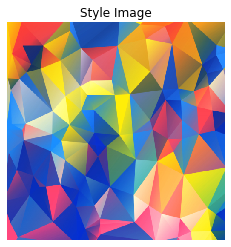

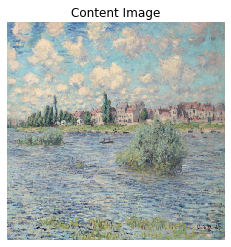

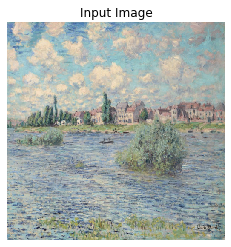

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


run [50]:
Style Loss : 0.744544 Content Loss: 23.225637

run [100]:
Style Loss : 0.635363 Content Loss: 19.779186

run [150]:
Style Loss : 0.631519 Content Loss: 18.041086

run [200]:
Style Loss : 0.639443 Content Loss: 16.942753

run [250]:
Style Loss : 0.628665 Content Loss: 16.237299

run [300]:
Style Loss : 0.635439 Content Loss: 15.728523

run [350]:
Style Loss : 0.632710 Content Loss: 15.377478

run [400]:
Style Loss : 0.637381 Content Loss: 15.102976

run [450]:
Style Loss : 0.637088 Content Loss: 14.904281

run [500]:
Style Loss : 0.637564 Content Loss: 14.745295

run [550]:
Style Loss : 0.641219 Content Loss: 14.617635

run [600]:
Style Loss : 0.643702 Content Loss: 14.513900



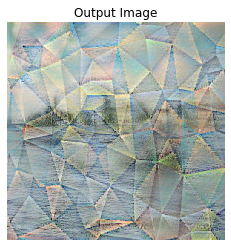

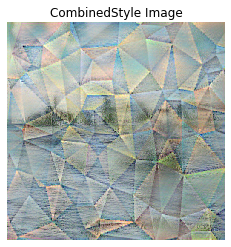

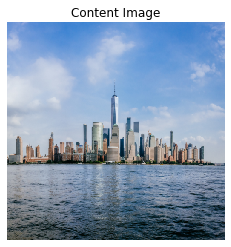

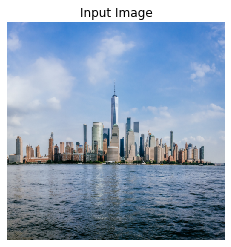

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 6.290855 Content Loss: 22.103863

run [100]:
Style Loss : 2.698389 Content Loss: 12.740228

run [150]:
Style Loss : 1.825337 Content Loss: 8.027183

run [200]:
Style Loss : 1.345777 Content Loss: 5.216117

run [250]:
Style Loss : 1.042685 Content Loss: 3.574916

run [300]:
Style Loss : 0.832694 Content Loss: 2.519287

run [350]:
Style Loss : 0.677120 Content Loss: 1.852484

run [400]:
Style Loss : 0.547750 Content Loss: 1.380472

run [450]:
Style Loss : 0.455182 Content Loss: 1.053214

run [500]:
Style Loss : 0.379564 Content Loss: 0.828492

run [550]:
Style Loss : 0.322086 Content Loss: 0.663663

run [600]:
Style Loss : 0.277372 Content Loss: 0.544771



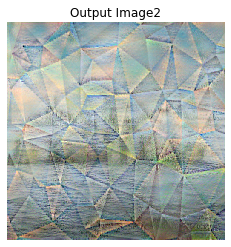

In [0]:
NOISY_START = False
SHOW_INPUT = True

STYLE_WEIGHT = 1000000
CONTENT_WEIGHT = 1
ITERATIONS = 600
!ls
style_img = image_loader("low_poly.png")
content_img = image_loader("ny.jpg")
style_img2 = image_loader("monet.jpg")
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

input_img = style_img2.clone()
if NOISY_START:
    input_img = torch.normal(style_img2.data, 0.1)
    input_img.data.clamp_(0, 1)

plt.ion()

if SHOW_INPUT:
    plt.figure()
    imshow(style_img, title='Style Image')

    plt.figure()
    imshow(style_img2, title='Content Image')

    plt.figure()
    imshow(input_img, title='Input Image')


output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            style_img, style_img2, input_img, num_steps=ITERATIONS,
                            style_weight=STYLE_WEIGHT, content_weight=CONTENT_WEIGHT)
plt.figure()
imshow(output, title='Output Image')

input_img = content_img.clone()
if NOISY_START:
    input_img = torch.normal(content_img.data, 0.1)
    input_img.data.clamp_(0, 1)

if SHOW_INPUT:
    plt.figure()
    imshow(output, title='CombinedStyle Image')

    plt.figure()
    imshow(content_img, title='Content Image')

    plt.figure()
    imshow(input_img, title='Input Image')

output2 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            output, style_img2, input_img, num_steps=ITERATIONS,
                            style_weight=STYLE_WEIGHT, content_weight=CONTENT_WEIGHT)

plt.figure()
imshow(output2, title='Output Image2')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()


#Weighted Multi-Style Transfer

colors.jpg    monet.jpg  output.png  sample_data  starry.jpg
low_poly.png  ny.jpg	 roses.jpg   selfie.jpg


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


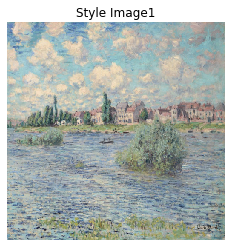

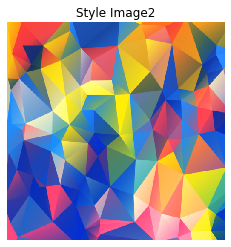

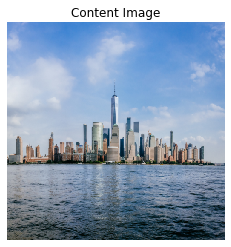

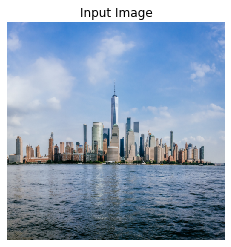

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


run [50]:
Style Loss : 1754.892944 Content Loss: 9.462277

run [100]:
Style Loss : 1735.278442 Content Loss: 8.588011

run [150]:
Style Loss : 1730.385254 Content Loss: 7.516206

run [200]:
Style Loss : 1728.680420 Content Loss: 6.504754

run [250]:
Style Loss : 1727.847534 Content Loss: 5.923694

run [300]:
Style Loss : 1727.261841 Content Loss: 5.536279

run [350]:
Style Loss : 1726.822998 Content Loss: 5.276033

run [400]:
Style Loss : 1726.498413 Content Loss: 5.061125

run [450]:
Style Loss : 1726.277954 Content Loss: 4.894588

run [500]:
Style Loss : 1726.121460 Content Loss: 4.744774

run [550]:
Style Loss : 1726.008911 Content Loss: 4.632304

run [600]:
Style Loss : 1725.925659 Content Loss: 4.531401



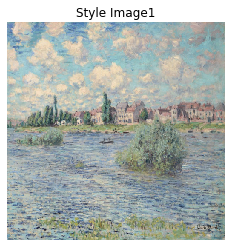

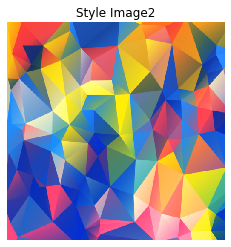

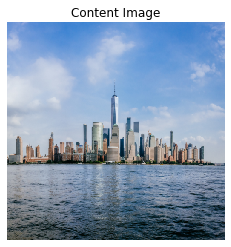

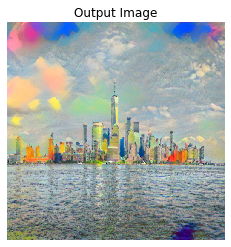

In [0]:
NOISY_START = False
SHOW_INPUT = True

STYLE_WEIGHT = 1000000
CONTENT_WEIGHT = 1
MULTISTYLE_WEIGHT = 0.9
ITERATIONS = 600
!ls
content_img = image_loader("ny.jpg")
style_img = image_loader("monet.jpg")
style_img2 = image_loader("low_poly.png")
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

input_img = content_img.clone()
if NOISY_START:
    input_img = torch.normal(content_img.data, 0.01)
    input_img.data.clamp_(0, 1)

plt.ion()

if SHOW_INPUT:
    plt.figure()
    imshow(style_img, title='Style Image1')

    plt.figure()
    imshow(style_img2, title='Style Image2')

    plt.figure()
    imshow(content_img, title='Content Image')

    plt.figure()
    imshow(input_img, title='Input Image')


output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, style_img2, multi_style_weight=MULTISTYLE_WEIGHT,
                            num_steps=ITERATIONS, style_weight=STYLE_WEIGHT, content_weight=CONTENT_WEIGHT)

plt.figure()
imshow(style_img, title='Style Image1')

plt.figure()
imshow(style_img2, title='Style Image2')

plt.figure()
imshow(content_img, title='Content Image')

plt.figure()
imshow(output, title='Output Image', save='output.png')